# EFICIENCIA DE OPERADORES TELEFONICOS

El servicio de telefonía virtual CallMeMaybe demanda de una una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. 

Este analisis ayudara a estudiar a los operadores ineficaces de CallMeMaybe, con el fin de brindar información relevante para mejorar la eficiencia operativa.

El objetivo principal es identificar operadores con un alto número de llamadas perdidas, tiempos de espera prolongados para llamadas entrantes y pocas llamadas salientes, si corresponde. Para determinar lo eficaz del operador.


Esta informacion sera dirigida a los supervisores que gestionan el rendimiento de los operadores. Con el objetivo de que tomen decisiones para mejorar la asignación de recursos, capacitación de operadores y ajustes en el manejo de llamadas.

## Importacion de librerias y lectura de datos

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math as mt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest 
import statsmodels.api as sm

In [2]:
com = pd.read_csv('/datasets/telecom_dataset_us.csv')
clientes = pd.read_csv('/datasets/telecom_clients_us.csv')

## Preprocesamiento de datos

In [3]:
# crear funcion para ver informacion generaal de cada df
def info (data):
    display(data.sample(5))
    print(data.info())
    print('Cantidad de filas duplicadas = ', data.duplicated().sum())
    print('Cantidad de datos ausentes = ', data.isnull().sum())
    display(data.describe(include='all'))

In [4]:
# uso de funcion para ver df telcom
info(com)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
4651,166511,2019-09-30 00:00:00+03:00,out,False,891416.0,True,3,0,3
35312,167532,2019-09-26 00:00:00+03:00,out,True,917852.0,True,1,0,4
17516,166939,2019-11-23 00:00:00+03:00,in,False,NaN,True,3,0,75
44413,168041,2019-11-26 00:00:00+03:00,in,False,934534.0,False,10,393,532
40840,167828,2019-10-17 00:00:00+03:00,in,False,NaN,True,7,0,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None
Cantidad de filas duplicadas =  4900
Cantidad de datos ausentes =  user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
cal

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,53902.000000,53902,53902,53785,45730.000000,53902,53902.000000,53902.000000,53902.000000
unique,NaN,119,2,2,NaN,2,NaN,NaN,NaN
top,NaN,2019-11-25 00:00:00+03:00,out,False,NaN,False,NaN,NaN,NaN
freq,NaN,1220,31917,47621,NaN,30334,NaN,NaN,NaN
mean,167295.344477,NaN,NaN,NaN,916535.993002,NaN,16.451245,866.684427,1157.133297
std,598.883775,NaN,NaN,NaN,21254.123136,NaN,62.917170,3731.791202,4403.468763
min,166377.000000,NaN,NaN,NaN,879896.000000,NaN,1.000000,0.000000,0.000000
25%,166782.000000,NaN,NaN,NaN,900788.000000,NaN,1.000000,0.000000,47.000000
50%,167162.000000,NaN,NaN,NaN,913938.000000,NaN,4.000000,38.000000,210.000000
75%,167819.000000,NaN,NaN,NaN,937708.000000,NaN,12.000000,572.000000,902.000000


In [5]:
len(com['user_id'].value_counts()) #exiten 307 clientes para analizar sobre sus llamadas

307

In [6]:
len(com['operator_id'].value_counts()) #exiten 1092 operadores en la empresa de telecomunicaciones

1092

In [7]:
# Eliminar duplicados exactos 
telcom = com.drop_duplicates()

In [8]:
telcom = telcom.dropna(subset=['operator_id','internal']).reset_index() # borrar nulos 

Para la columna internal, la eliminación de registros con valores ausentes es segura dado el bajo porcentaje.

In [9]:
telcom.info() # observar cantidad de datos existen posterior a la eliminacion 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                41491 non-null  int64  
 1   user_id              41491 non-null  int64  
 2   date                 41491 non-null  object 
 3   direction            41491 non-null  object 
 4   internal             41491 non-null  object 
 5   operator_id          41491 non-null  float64
 6   is_missed_call       41491 non-null  bool   
 7   calls_count          41491 non-null  int64  
 8   call_duration        41491 non-null  int64  
 9   total_call_duration  41491 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 2.9+ MB


In [10]:
len(telcom['user_id'].value_counts()) # observar si o no afecto a la cantidad de clientes analizdos

290

In [11]:
((290-307)/290)*100 # calcular el porcentaje de datos perdidos por la elimincacion de datos nulos

-5.862068965517241

In [12]:
len(telcom['operator_id'].value_counts()) 

1092

Al eliminar las filas duplicadas y los valores nulos de las columnas 'internal' y 'operator_id', el numero de clientes analizados baja en un 5%. Y el numero de operadores no se ve afectado al eliminar esa data. Por lo tanto, al eliminar datos duplicados y nulos, afecta en la cantidad de datos de usuarios, no asi la cantidad de operadores, esta ultima sigue intacta.

In [13]:
# Convertir tipo object a datetime
telcom['date'] = pd.to_datetime(telcom['date'])

In [14]:
# convertir tipos de datos
telcom['internal'] = telcom['internal'].astype(bool) # de entero a booleano
telcom['operator_id'] = telcom['operator_id'].astype(int) # de float a entero

In [15]:
# crear columna de duracion de llamda en minutos
telcom['total_call_duration_min'] = round(telcom['total_call_duration']/60) 
telcom['call_duration_min'] = round(telcom['call_duration']/60) 

In [16]:
# crear columna de tiempo de espera en segundos
telcom['tiempo_espera_seg'] = round(telcom['total_call_duration']-telcom['call_duration'])

In [17]:
# crear columna de tiempo de espera en minutos
telcom['tiempo_espera_min'] = round((telcom['total_call_duration']-telcom['call_duration'])/60 , 1)

In [18]:
info(telcom)

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,total_call_duration_min,call_duration_min,tiempo_espera_seg,tiempo_espera_min
22660,29739,167264,2019-10-13 00:00:00+03:00,in,False,919554,False,15,1198,1656,28.0,20.0,458,7.6
27857,36426,167626,2019-09-27 00:00:00+03:00,out,False,919188,True,113,0,3123,52.0,0.0,3123,52.0
7957,10216,166678,2019-08-31 00:00:00+03:00,in,False,888868,False,1,34,42,1.0,1.0,8,0.1
33629,44071,168021,2019-11-15 00:00:00+03:00,out,False,939224,True,50,0,472,8.0,0.0,472,7.9
7555,9706,166658,2019-11-15 00:00:00+03:00,out,False,890404,True,11,0,235,4.0,0.0,235,3.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype                                
---  ------                   --------------  -----                                
 0   index                    41491 non-null  int64                                
 1   user_id                  41491 non-null  int64                                
 2   date                     41491 non-null  datetime64[ns, pytz.FixedOffset(180)]
 3   direction                41491 non-null  object                               
 4   internal                 41491 non-null  bool                                 
 5   operator_id              41491 non-null  int64                                
 6   is_missed_call           41491 non-null  bool                                 
 7   calls_count              41491 non-null  int64                                
 8   call_duration            41491 non-null  int64

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,total_call_duration_min,call_duration_min,tiempo_espera_seg,tiempo_espera_min
count,41491.000000,41491.000000,41491,41491,41491,41491.000000,41491,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000
unique,NaN,NaN,118,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2019-11-25 00:00:00+03:00,out,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,987,28813,36161,NaN,27382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2019-08-02 00:00:00+03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-11-28 00:00:00+03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,27092.318334,167301.113543,NaN,NaN,NaN,916516.771155,NaN,16.921381,1010.940011,1323.153238,22.042419,16.843315,312.213227,5.203119
std,15606.824533,600.513986,NaN,NaN,NaN,21234.081589,NaN,59.786187,4066.666485,4788.953155,79.818464,67.779165,1176.102940,19.602044
min,1.000000,166377.000000,NaN,NaN,NaN,879896.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13496.500000,166782.000000,NaN,NaN,NaN,900790.000000,NaN,1.000000,0.000000,67.000000,1.000000,0.000000,19.000000,0.300000


In [19]:
# variacion porcentual de datos manipulados
((len(telcom)-len(com))/len(telcom))*100

-29.912511146995733

Luego de las modificaciones, el df telcom cuenta con 41491 datos, 30% menos que los datos originales y con 14 columnas que describen el comportamiento de los operadoradores de llamadas. Sin filas duplicadas ni valores ausentes. 

En promedio una llamada dura 16 minutos sin contar el tiempo de espera, lo maximo que duro una llamada fue 2407 minutos(40 horas), particularidad que debe haber sido un error, al igual que tiempo de espera maximo de 774 minutos(12 horas). En cuanto al de tiempo de espera de un cliente es 5 minutos. 

In [20]:
# uso de funcion para ver df clientes
info(clientes)

,user_id,tariff_plan,date_start
306,167252,C,2019-09-09
67,166681,A,2019-08-14
389,167473,C,2019-09-18
347,167035,C,2019-08-29
144,168264,C,2019-10-18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None
Cantidad de filas duplicadas =  0
Cantidad de datos ausentes =  user_id        0
tariff_plan    0
date_start     0
dtype: int64


,user_id,tariff_plan,date_start
count,732.000000,732,732
unique,NaN,3,73
top,NaN,C,2019-09-24
freq,NaN,395,24
mean,167431.927596,NaN,NaN
std,633.810383,NaN,NaN
min,166373.000000,NaN,NaN
25%,166900.750000,NaN,NaN
50%,167432.000000,NaN,NaN
75%,167973.000000,NaN,NaN


In [21]:
# convertir tipo de dato
clientes['date_start'] = pd.to_datetime(clientes['date_start']) # de numero entero a fecha

In [22]:
len(clientes['date_start'].value_counts()) # cantidad de clientes analizados en este df

73

In [23]:
clientes.describe(include='all')

,user_id,tariff_plan,date_start
count,732.000000,732,732
unique,NaN,3,73
top,NaN,C,2019-09-24 00:00:00
freq,NaN,395,24
first,NaN,NaN,2019-08-01 00:00:00
last,NaN,NaN,2019-10-31 00:00:00
mean,167431.927596,NaN,NaN
std,633.810383,NaN,NaN
min,166373.000000,NaN,NaN
25%,166900.750000,NaN,NaN


clientes es un df que cuenta con informacion de 73 clientes, contiene 3 columnas que describe su id, tarifa actual a la que pertenece y su fecha de registro. Cuenta con 732 filas ninguna de ellas duplicadas ni con valores ausentes. 

La tarifa mas popular es de tipo C y el primer registro fue el 01 de agosto de 2019 y el ultimo fue 31 de octubre de 2019. El dia que tuvieron mas registros fue el 24 de septiembre del 2019.


## EDA

### Visualizar las distribuciones de llamadas perdidas, tiempos de espera y llamadas salientes.

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0, 0.5, 'Frecuencia')

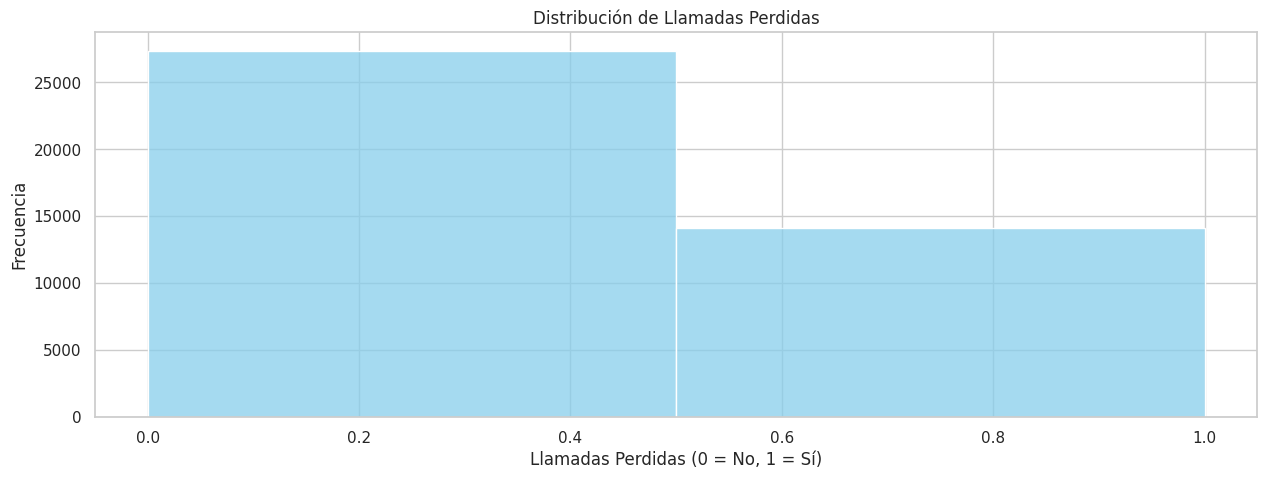

In [24]:
# Configuración de estilo
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico 1: Distribución de llamadas perdidas
#plt.subplot(1, 3, 1)
sns.histplot(data=telcom, x='is_missed_call', bins=2, kde=False, color='skyblue')
plt.title('Distribución de Llamadas Perdidas')
plt.xlabel('Llamadas Perdidas (0 = No, 1 = Sí)')
plt.ylabel('Frecuencia')

La distribución de llamadas perdidas, según el gráfico, muestra que la mayoría de las llamadas no fueron perdidas (representadas en el valor "0"), mientras que una cantidad menor de llamadas sí se considera perdida (representada en el valor "1"). Esto implica que en general los operadores están respondiendo o atendiendo una mayoría de llamadas, aunque aún existe un número significativo de llamadas perdidas.

(0.0, 300.0)

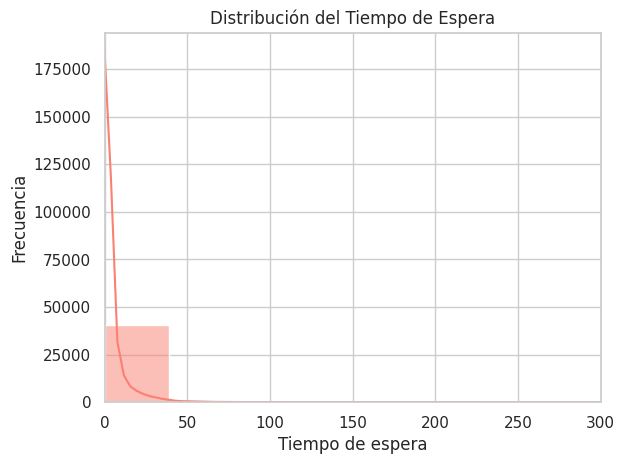

In [25]:
# Distribución de tiempo de espera
sns.histplot(data=telcom, x='tiempo_espera_min', bins=20, kde=True, color='salmon')
plt.title('Distribución del Tiempo de Espera')
plt.xlabel('Tiempo de espera')
plt.ylabel('Frecuencia')
plt.xlim([0,300])

La distribución del tiempo de espera muestra una clara concentración de llamadas con tiempos de espera muy cortos, mientras que los tiempos de espera largos son poco frecuentes. La mayoría de las llamadas tienen tiempos de espera por debajo de los 40 minutos, y el volumen de llamadas cae drásticamente a medida que el tiempo de espera aumenta.

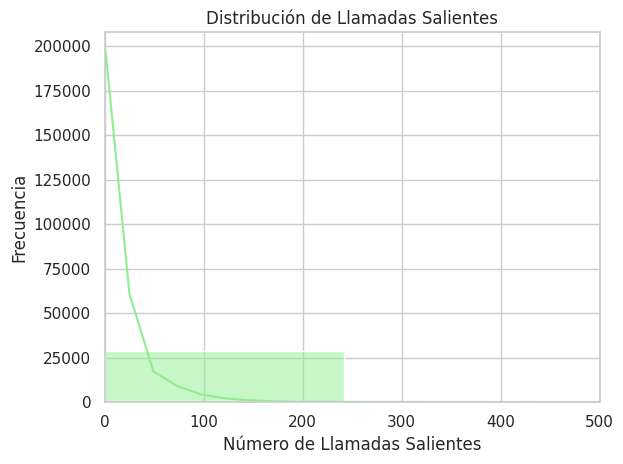

In [26]:
# Distribución de llamadas salientes
#plt.subplot(1, 3, 3)
sns.histplot(data=telcom[telcom['direction'] == 'out'], x='calls_count', bins=20, kde=True, color='lightgreen')
plt.title('Distribución de Llamadas Salientes')
plt.xlabel('Número de Llamadas Salientes')
plt.ylabel('Frecuencia')
plt.xlim([0,500])
plt.tight_layout()
plt.show()

La distribución del numero de llamadas salientes muestra una clara concentración entre 0 a 200 llamadas.

### Revisar valores atipicos

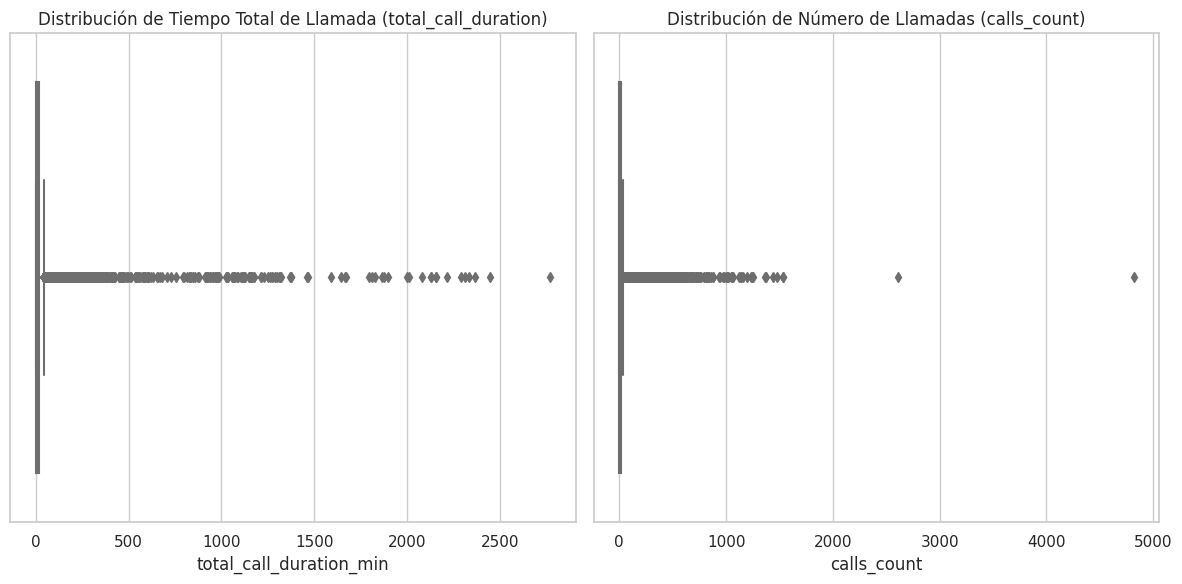

In [27]:
# Visualizar los datos atípicos usando boxplot
plt.figure(figsize=(12, 6))

# Boxplot para la columna duracion total de llamada en minutos 
plt.subplot(1, 2, 1)
sns.boxplot(data=telcom, x='total_call_duration_min', color='skyblue')
plt.title('Distribución de Tiempo Total de Llamada (total_call_duration)')

# Boxplot para cantidad de llamadas
plt.subplot(1, 2, 2)
sns.boxplot(data=telcom, x='calls_count', color='salmon')
plt.title('Distribución de Número de Llamadas (calls_count)')

plt.tight_layout()
plt.show()


Ambas distribuciones están sesgadas a la derecha, lo cual es típico en datos de duración y conteo, donde la mayoría de los valores están concentrados en un rango bajo, pero existen algunos casos que destacan por ser extremadamente altos.

En el caso de total_call_duration, vemos puntos que alcanzan valores muy elevados, superiores a los 1000 minutos, lo cual podría indicar operadores que han acumulado tiempos de espera anormalmente altos.

En calls_count, también se observan valores fuera de lo común, incluso algunos que llegan hasta 5000 llamadas, lo cual podría representar una sobrecarga de trabajo o un error en los datos.
Asimetría en la distribución:


### Analizar la relación entre el tiempo de espera y la cantidad de llamadas perdidas.

In [28]:
# Calcular la correlación entre el tiempo de espera y la cantidad de llamadas perdidas
correlation = telcom[['tiempo_espera_min', 'is_missed_call']].corr().iloc[0, 1]
print(f"Correlación entre el tiempo de espera y la probabilidad de llamada perdida: {correlation:.2f}")

Correlación entre el tiempo de espera y la probabilidad de llamada perdida: 0.08


La correlacion que muestra el tiempo de espera y la probabilidad de llamada perdida es positiva, es decir, mientras aumenta el tiempo de espera, mas llamadas perdidas hay.

### Analizar la cantidad de llamadas internas y externas

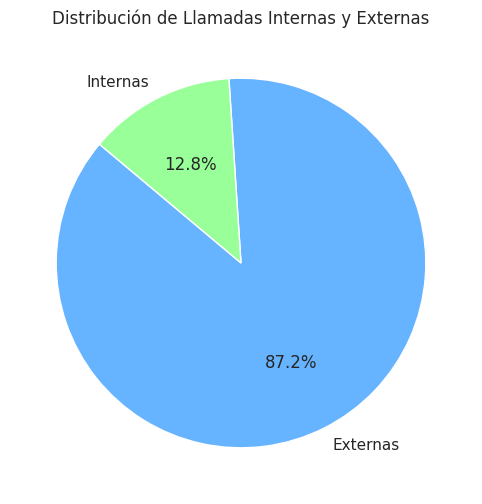

In [29]:
# Crear un conteo de las llamadas internas y externas
call_counts = telcom['internal'].value_counts()

# Trazar el gráfico circular
plt.figure(figsize=(8, 6))
plt.pie(call_counts, labels=['Externas', 'Internas'], autopct='%1.1f%%', startangle=140,colors=['#66b3ff', '#99ff99'])
plt.title('Distribución de Llamadas Internas y Externas')
plt.show()

Al analizar la cantidad de llamadas internas y externas, se puede determinar que un 87,2% de las llamadas son externas, por lo tanto, se puede deducir que la mayoria de los operadores cumple con su tarea de realizar llamar a los clientes mas que a otros operadores.

## Definir metricas

- Calcular cantidad de llamadas perdidas por operador.
- Calcular el tiempo promedio de espera de llamadas y duracion promedio de llamadas por operador.
- Calcular el número de llamadas salientes por operador.
- Calcular porcentajes de llamadas perdidas y llamadas salientes.
- Clasificar a los operadores en categorías bajo o alto según los umbrales establecidos.

In [30]:
# Tabla con los datos para cada operador como su número de llamadas (salientes, entrantes, perdidas y totales)
operators = telcom.groupby('operator_id').agg({'calls_count': 'sum', 
                                               'is_missed_call': 'sum', 
                                               'tiempo_espera_seg': 'mean',
                                              'call_duration_min': 'mean',}).reset_index()
operators.rename (columns= {'calls_count': 'llamadas_totales',
                           'is_missed_call': 'llamadas_perdidas',
                           "tiempo_espera_seg": "tiempo_espera_prom_seg",
                            "call_duration_min": "duracion_llamada_prom_min"}, inplace=True)
# Tabla de llamadas entrantes y salientes
operator_direction = telcom.groupby(['operator_id', 'direction'])['calls_count'].sum().reset_index()

# Juntamos ambas tablas para crear una tabla unificada
operator_data = operators.merge(operator_direction.query('direction == "in"')[['operator_id','calls_count']], on='operator_id')
operator_data = operators.merge(operator_direction.query('direction == "out"')[['operator_id','calls_count']], on='operator_id')
operator_data.rename(columns={"calls_count": "llamadas_salientes"}, inplace=True)
operator_data


,operator_id,llamadas_totales,llamadas_perdidas,tiempo_espera_prom_seg,duracion_llamada_prom_min,llamadas_salientes
0,879896,930,47,104.914530,9.051282,872
1,879898,7312,89,459.690265,18.969027,7209
2,880020,45,6,14.000000,1.900000,38
3,880022,197,29,53.971429,3.571429,189
4,880026,2232,87,121.978022,14.043956,2208
...,...,...,...,...,...,...
877,972408,6,1,22.500000,1.500000,6
878,972410,77,2,374.500000,15.750000,77
879,972412,61,2,210.000000,11.600000,60
880,972460,51,3,88.571429,2.857143,50


In [31]:
operator_data['%_perdidas'] = round((operator_data['llamadas_perdidas'] / operator_data['llamadas_totales']) * 100)
operator_data['%_salientes'] = round((operator_data['llamadas_salientes'] / operator_data['llamadas_totales']) * 100)

In [32]:
#Observar los porcentajes de llamadas perdidas que mas se repiten
operator_data['%_perdidas'].value_counts().tail()

43.0    1
38.0    1
35.0    1
26.0    1
71.0    1
Name: %_perdidas, dtype: int64

In [33]:
#Observar los porcentajes de llamadas salientes que mas se repiten
operator_data['%_salientes'].value_counts().head()

100.0    352
99.0      25
98.0      20
50.0      18
94.0      14
Name: %_salientes, dtype: int64

**Con estos datos se puede clasificar a los operadores con rendimiento bajo de acuerdo a las siguientes condiciones:**

    - Operador con mas de 15% de llamadas perdidas
    - Operador con menos del 90% de llamadas salientes

In [34]:
# clasificar con numpy a los operadores de acuerdo a la condiciones anteriores 
operator_data['rendimiento'] = np.where(
    (operator_data['%_perdidas'] > 15) & (operator_data['%_salientes'] < 90),
    'bajo',
    'alto')

In [35]:
# cantidad de operadores clasificado por rendimiento
operator_data.groupby('rendimiento')['operator_id'].count()

rendimiento
alto    800
bajo     82
Name: operator_id, dtype: int64

De 882 operadores, el 91% son oepradores con un alto rendimiento, es decir, son eficaces. El 9% restantes se cataloga como operador ineficaz

In [36]:
# promedio de porcentaje de llamadas perdidas clasificadas por el rendimiento de los operadores 
operator_data.groupby('rendimiento')['%_perdidas'].mean()

rendimiento
alto    10.807500
bajo    25.597561
Name: %_perdidas, dtype: float64

In [37]:
# promedio de porcentaje de llamadas salientes clasificadas por el rendimiento de los operadores 
operator_data.groupby('rendimiento')['%_salientes'].mean()

rendimiento
alto    81.390000
bajo    61.170732
Name: %_salientes, dtype: float64

## Prueba de hipotesis

### Hipotesis 1: Tiempo promedio de espera en segundos operadores de bajo y alto rendimiento

H0 (Hipótesis nula): No hay diferencia significativa en el tiempo promedio de espera de los operadores de bajo rendimiento y alto rendimiento

H1 (Hipótesis alternativa): Hay diferencia significativa en el tiempo promedio de espera de los operadores de bajo rendimiento y alto rendimiento

In [38]:
t_alto= operator_data.query("rendimiento=='alto'")['tiempo_espera_prom_seg']
t_bajo = operator_data.query("rendimiento=='bajo'")['tiempo_espera_prom_seg']

In [39]:
var_alto = np.var(t_alto)
var_bajo = np.var(t_bajo)
print(var_alto)
print(var_bajo)

333243.10092377756
145.39944637006548


In [40]:
# prueba levene para evaluar si las varianzas de los grupos son iguales
alpha = 0.05
pruebat = st.levene(t_alto, t_bajo, center='mean')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 4.255817055318088e-09
Rechazo la hipotesis


Hallazgos prueba levene: El valor p resultante es 4.25e-09 por lo tanto es menor a 0.05 y determina que las muestras tienen varianzas diferentes.

In [41]:
alpha = 0.05
pruebat = st.ttest_ind(t_alto, t_bajo, equal_var='False')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 4.644669925736865e-05
Rechazo la hipotesis


Hallazgos: Dado que el valor p (4.64e-05) es menor que el nivel de significancia (0.05), se rechaza la hipótesis nula (H₀). Esto indica que existe una diferencia significativa en el tiempo promedio de espera entre los operadores de alto y bajo rendimiento.

### Hipotesis 2: Porcentaje promedio de llamadas perdidas entre operadores de alto y bajo rendimiento
H0 (Hipótesis nula): No hay diferencia significativa en el porcentaje promedio de llamadas perdidas de los operadores de bajo rendimiento y alto rendimiento

H1 (Hipótesis alternativa): Hay diferencia significativa en el porcentaje promedio de llamadas perdidas de los operadores de bajo rendimiento y alto rendimiento


In [42]:
r_alto= operator_data.query("rendimiento=='alto'")['%_perdidas']
r_bajo = operator_data.query("rendimiento=='bajo'")['%_perdidas']

In [43]:
var_alto = np.var(r_alto)
var_bajo = np.var(r_bajo)
print(var_alto)
print(var_bajo)

326.21794374999996
100.2648720999405


In [44]:
# prueba levene para evaluar si las varianzas de los grupos son iguales
alpha = 0.05
pruebat = st.levene(r_alto, r_bajo, center='mean')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 0.2321312595449601
No puedo rechazar la hipotesis


Hallazgos prueba levene: El valor p resultante es 0.23 por lo tanto es mayor a 0.05 y determina que las muestras tienen varianzas similares

In [45]:
alpha = 0.05
pruebat = st.ttest_ind(r_alto, r_bajo, equal_var='True')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 6.767592902970817e-13
Rechazo la hipotesis


Hallazgos: Dado que el valor p (6.77e-13) es considerablemente menor que el nivel de significancia (0.05), se rechaza la hipótesis nula (H₀). Esto sugiere que existe una diferencia significativa en el porcentaje promedio de llamadas perdidas entre los operadores de alto y bajo rendimiento.

### Hipotesis 3: Porcentaje promedio de llamadas salientes entre operadores de alto y bajo rendimiento
H0 (Hipótesis nula): No hay diferencia significativa en el porcentaje promedio de llamadas salientes de los operadores de bajo rendimiento y alto rendimiento

H1 (Hipótesis alternativa): Hay diferencia significativa en el porcentaje promedio de llamadas salientes de los operadores de bajo rendimiento y alto rendimiento

In [46]:
s_alto= operator_data.query("rendimiento=='alto'")['%_salientes']
s_bajo = operator_data.query("rendimiento=='bajo'")['%_salientes']

In [47]:
var_alto = np.var(s_alto)
var_bajo = np.var(s_bajo)
print(var_alto)
print(var_bajo)

749.0253999999998
383.5806067816776


In [48]:
alpha = 0.05
pruebat = st.levene(s_alto, s_bajo, center='mean')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 0.006007165160059563
Rechazo la hipotesis


Hallazgos prueba levene: El valor p resultante es 0.006 por lo tanto es menor a 0.05 y determina que las muestras tienen varianzas diferentes

In [49]:
alpha = 0.05
pruebat = st.ttest_ind(s_alto, s_bajo, equal_var='False')
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 1.2325548720269263e-10
Rechazo la hipotesis


Hallazgos: Dado que el valor p (1.23e-10) es considerablemente menor que el nivel de significancia (0.05), se rechaza la hipótesis nula (H₀). Esto sugiere que existe una diferencia significativa en el porcentaje promedio de llamadas salientes entre operadores de alto y bajo rendimiento.

## Conclusiones generales

Si el objetivo es reducir la ineficiencia, el gráfico de distribución de llamadas perdidas sugiere que, aunque las llamadas perdidas no dominan, aún hay margen para reducirlas, ya que una fracción considerable no está siendo atendida. Es importante investigar más a fondo para identificar si ciertas condiciones (sobredemanda) contribuyen a este porcentaje de llamadas perdidas.

La distribución de tiempo de espera apunta que, en general, los operadores están atendiendo las llamadas con relativa rapidez, pero es posible que los tiempos de espera largos correspondan a ciertos momentos de alta demanda o a operadores específicos.


Se estudio la correlación entre el tiempo de espera y la probabilidad de llamada perdida, la cual dio un resultado de una correlación positiva, es decir, mientras aumenta el tiempo de espera, más llamadas perdidas hay.

Con 882 operadores se calculo la cantidad de llamadas perdidas por operador, el tiempo promedio de espera de llamadas, el número de llamadas salientes por operador y se calcularon porcentajes de llamadas perdidas y llamadas salientes. Para poder clasificar el rendimiento de cada operador, es decir, calificarlo como eficaz o ineficaz.
Con estos datos se pudo clasificar a los operadores con rendimiento bajo de acuerdo a las siguientes condiciones:
- Operador con más de 15% de llamadas perdidas
- Operador con menos del 90% de llamadas salientes

Ya clasificados los 882 operadores, el 91% son operadores con un alto rendimiento, es decir, son eficaces. Y el 9% restantes se cataloga como operador ineficaz. De acuerdo a esto se realizaron las siguientes prueba de hipotesis y se concluyó. 

- **Hipotesis 1: Tiempo promedio de espera en segundos operadores de bajo y alto rendimiento.** Los resultados sugieren que el rendimiento del operador está relacionado con el tiempo promedio de espera, con diferencias estadísticamente significativas entre operadores de alto y bajo rendimiento.
- **Hipotesis 2: Porcentaje promedio de llamadas perdidas entre operadores de alto y bajo rendimiento.** Los resultados indican que el rendimiento del operador está asociado con el porcentaje de llamadas perdidas, lo cual implica que los operadores de distinto rendimiento presentan diferencias estadísticamente significativas en cuanto a la cantidad de llamadas que no logran atender.
- **Hipótesis 3: Porcentaje promedio de llamadas salientes entre operadores de alto y bajo rendimiento.** Los resultados indican que el rendimiento del operador tiene un impacto significativo en el porcentaje de llamadas salientes, mostrando diferencias estadísticamente significativas entre operadores de distinto rendimiento.

Se sugiere utilizar este estudio para volver a capacitar al 9% de los operadores clasificados como ineficaces y obtener que es lo que hace mejor a los operadores eficaces.

## Fuentes

https://plotly.com/python/pie-charts/

https://blog.hubspot.es/service/metricas-call-center

https://numpy.org/doc/stable/reference/generated/numpy.where.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

https://docs.scipy.org/doc/scipy/reference/stats.html

## Presentacion en pdf

https://drive.google.com/file/d/13uoabYnZS9hNksXGb1bdovfCbfE7zXBW/view?usp=sharing